In [32]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt


In [15]:
bit_sequences = [
    [0, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1, 1],
]

token_sequences = [[str(bit) for bit in bit_sequence] for bit_sequence in bit_sequences]

In [21]:
import torch
from torch.utils.data import Dataset

class BitDataset(Dataset):
    def __init__(self, token_sequences, seq_length):
        self.token_sequences = token_sequences
        self.seq_length = seq_length

    def __len__(self):
        return sum([len(tokens) - self.seq_length for tokens in self.token_sequences])

    def __getitem__(self, idx):
        for tokens in self.token_sequences:
            if idx < len(tokens) - self.seq_length:
                x = tokens[idx:idx + self.seq_length]
                y = tokens[idx + 1:idx + self.seq_length + 1]
                return torch.tensor([int(token) for token in x], dtype=torch.long), torch.tensor([int(token) for token in y], dtype=torch.long)
            idx -= len(tokens) - self.seq_length
        raise IndexError("Index out of bounds")

seq_length = 4
dataset = BitDataset(token_sequences, seq_length)


In [26]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, dim_feedforward)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x_embed = self.embedding(x)
        
        # Create a dummy target tensor with the same dimensions as the source tensor
        tgt = torch.zeros_like(x_embed)
        
        x_transformed = self.transformer(x_embed, tgt)
        x_out = self.fc(x_transformed)
        return x_out



In [27]:
vocab_size = 2  # Since you have only two tokens: '0' and '1'
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 128

model = TransformerModel(vocab_size, d_model, nhead, num_layers, dim_feedforward)


In [33]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
optimizer = Adam(model.parameters(), lr=1e-4)
loss_function = CrossEntropyLoss()

epochs = 10
loss_values = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for x, y in dataloader:
        optimizer.zero_grad()
        
        x = x.transpose(0, 1)
        y = y.transpose(0, 1)
        
        output = model(x)
        loss = loss_function(output.reshape(-1, vocab_size), y.reshape(-1))
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss}")


Epoch 1, Loss: 0.6843439340591431
Epoch 2, Loss: 0.673315147558848
Epoch 3, Loss: 0.7202104528745016
Epoch 4, Loss: 0.7034757335980734
Epoch 5, Loss: 0.6859739224116007
Epoch 6, Loss: 0.676751712958018
Epoch 7, Loss: 0.719402551651001
Epoch 8, Loss: 0.6538856228192648
Epoch 9, Loss: 0.748166024684906
Epoch 10, Loss: 0.6864680846532186


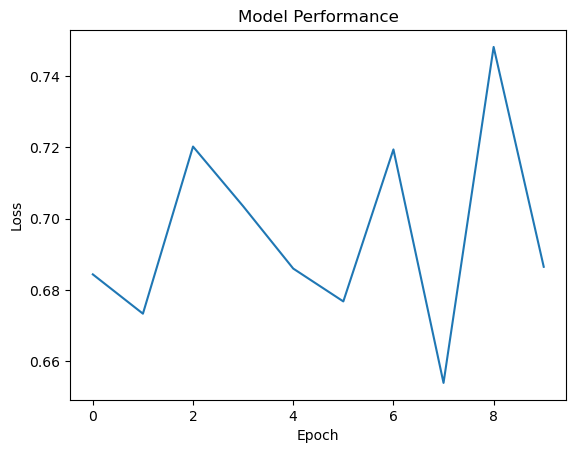

In [34]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Performance")
plt.show()